In [1]:
import json
import math
from typing import List, Optional, Tuple
import hydra
from omegaconf import DictConfig
from tqdm import tqdm
import torch
import numpy as np
from transformers import (
    AutoModelForCausalLM,
    AutoModelForMaskGeneration,
    AutoModelForZeroShotObjectDetection,
    AutoProcessor,
    GenerationConfig,
    Owlv2ForObjectDetection,
    SamModel,
    SamProcessor,
)
from scipy.stats import entropy
from torch import Tensor
from torch.nn.functional import cosine_similarity

In [2]:
import ollama
import os 
import matplotlib.pyplot as plt
import glob
import imageio
import cv2
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
path = "/media/parvez/One_Touch/Scenefun3D" 
split = "train_val_set"

In [4]:
intrinsic_file_path = "/media/parvez/One_Touch/Scenefun3D/train_val_set/420673/42445198/hires_wide_intrinsics"
image_file_path = "/media/parvez/One_Touch/Scenefun3D/train_val_set/420673/42445198/hires_wide"
transform_path = "/media/parvez/One_Touch/Scenefun3D/train_val_set/420673/42445198/42445198_transform.npy" 
pcd_file_path = "/media/parvez/One_Touch/Scenefun3D/train_val_set/420673/420673_laser_scan.ply"  
crop_file_path = "/media/parvez/One_Touch/Scenefun3D/train_val_set/420673/420673_crop_mask.npy" 

intrinsic_file = sorted(os.listdir(intrinsic_file_path))[243]
intrinsic_path = os.path.join(intrinsic_file_path, intrinsic_file)
image_file = sorted(os.listdir(image_file_path))[243]
image_path = os.path.join(image_file_path, image_file)
traj_path = "/media/parvez/One_Touch/Scenefun3D/train_val_set/420673/42445198/hires_poses.traj"

In [5]:
def get_data_asset_path(traj_path):
        """
        Get the file path for a specified data asset.

        Args:
            data_asset_identifier (str): A string identifier for the data asset.
            visit_id (str or int): The identifier for the visit (scene).
            video_id (str or int, optional): The identifier for the video sequence. Required if specified data asset requires a video identifier.

        Returns:
            (Path): A Path object representing the file path to the specified data asset.

        Raises:
            AssertionError: If the `data_asset_identifier` is not valid or if `video_id` is required but not provided.
        """
        assert data_asset_identifier in data_asset_to_path, f"Data asset identifier '{data_asset_identifier}' is not valid"

        data_path = data_asset_to_path[data_asset_identifier]

        if ("<video_id>" in data_path) and (video_id is None):
            assert False, f"video_id must be specified for the data asset identifier '{data_asset_identifier}'"

        visit_id = str(visit_id)

        data_path = (
            data_path
                .replace("<data_dir>", self.data_root_path)
                .replace("<visit_id>", visit_id)
        )

        if "<video_id>" in data_path:
            video_id = str(video_id)
            data_path = data_path.replace("<video_id>", video_id)

        return data_path


In [6]:
def convert_angle_axis_to_matrix3(angle_axis):
    """
    Converts a rotation from angle-axis representation to a 3x3 rotation matrix.

    Args:
        angle_axis (numpy.ndarray): A 3-element array representing the rotation in angle-axis form.

    Returns:
        (numpy.ndarray): A 3x3 rotation matrix representing the same rotation as the input angle-axis.

    Raises:
        ValueError: If the input is not a valid 3-element numpy array.
    """
    # Check if input is a numpy array
    if not isinstance(angle_axis, np.ndarray):
        raise ValueError("Input must be a numpy array.")
    
    # Check if the input is of shape (3,)
    if angle_axis.shape != (3,):
        raise ValueError("Input must be a 3-element array representing the rotation in angle-axis representation.")
    
    matrix, jacobian = cv2.Rodrigues(angle_axis)
    return matrix


In [7]:
def TrajStringToMatrix(traj_str):
        """ 
        Converts a line from the camera trajectory file into translation and rotation matrices.

        Args:
            traj_str (str): A space-delimited string where each line represents a camera pose at a particular timestamp. 
                            The line consists of seven columns:
                - Column 1: timestamp
                - Columns 2-4: rotation (axis-angle representation in radians)
                - Columns 5-7: translation (in meters)

        Returns:
            (tuple): A tuple containing:
                - ts (str): Timestamp.
                - Rt (numpy.ndarray): 4x4 transformation matrix representing rotation and translation.

        Raises:
            AssertionError: If the input string does not have exactly seven columns.
        """
        tokens = traj_str.split()
        assert len(tokens) == 7
        ts = tokens[0]

        # Rotation in angle axis
        angle_axis = [float(tokens[1]), float(tokens[2]), float(tokens[3])]
        r_w_to_p = convert_angle_axis_to_matrix3(np.asarray(angle_axis))

        # Translation
        t_w_to_p = np.asarray([float(tokens[4]), float(tokens[5]), float(tokens[6])])
        extrinsics = np.eye(4, 4)
        extrinsics[:3, :3] = r_w_to_p
        extrinsics[:3, -1] = t_w_to_p
        Rt = np.linalg.inv(extrinsics)

        return (ts, Rt)

In [8]:
def get_camera_trajectory(traj_path):
        """
        Retrieve the camera trajectory from a file and convert it into a dictionary whose keys are timestamps and 
        values are the corresponding camera poses.

        Args:
            visit_id (str): The identifier of the scene.
            video_id (str): The identifier of the video sequence.
            pose_source (str, optional): Specifies the trajectory asset type, either "colmap" or "arkit". Defaults to "colmap".

        Returns:
            (dict): A dictionary where keys are timestamps (rounded to 3 decimal points) and values are 4x4 transformation matrices representing camera poses.

        Raises:
            AssertionError: If an unsupported trajectory asset type is provided.
        """
        #assert pose_source in ["colmap", "arkit"], f"Unknown option {pose_source}"

        #data_asset_identifier = "hires_poses" if pose_source == "colmap" else "lowres_poses"
        traj_file_path = traj_path
        #print("traj_file_path = ", traj_file_path)

        with open(traj_file_path) as f:
            traj = f.readlines()

        # Convert trajectory to a dictionary
        poses_from_traj = {}
        for line in traj:
            traj_timestamp = line.split(" ")[0] 


            poses_from_traj[f"{traj_timestamp}"] = np.array(TrajStringToMatrix(line)[1].tolist())
            

        return poses_from_traj

In [9]:
def get_camera_intrinsics(intrinsics_path):
        """
        Retrieve the camera intrinsics for a given scene and video sequence.

        Args:
            visit_id (str): The identifier of the scene.
            video_id (str): The identifier of the video sequence.
            data_asset_identifier (str, optional): The data asset type for camera intrinsics.
                                                   Can be either "hires_wide_intrinsics" or "lowres_wide_intrinsics". 
                                                   Defaults to "hires_wide_intrinsics".

        Returns:
            (dict): A dictionary mapping timestamps to file paths of camera intrinsics data.

        Raises:
            ValueError: If an unsupported data asset identifier is provided.
            FileNotFoundError: If no intrinsics files are found at the specified path.
        """
        intrinsics_mapping = {}
        

        intrinsics = sorted(glob.glob(os.path.join(intrinsics_path, "*.pincam")))
        

        intrinsics_timestamps = [os.path.basename(x).split(".pincam")[0].split("_")[1] for x in intrinsics]

        # Create mapping from timestamp to full path
        intrinsics_mapping = {timestamp: cur_intrinsics for timestamp, cur_intrinsics in zip(intrinsics_timestamps, intrinsics)}

        return intrinsics_mapping

In [10]:
def read_camera_intrinsics(intrinsics_file_path, format="tuple"):
        """
        Parses a file containing camera intrinsic parameters and returns them in the specified format.

        Args:
            intrinsics_file_path (str): The path to the file containing camera intrinsic parameters.
            format (str, optional): The format in which to return the camera intrinsic parameters.
                                    Supported formats are "tuple" and "matrix". Defaults to "tuple".

        Returns:
            (Union[tuple, numpy.ndarray]): Camera intrinsic parameters in the specified format.

                - If format is "tuple", returns a tuple \\(w, h, fx, fy, hw, hh\\).
                - If format is "matrix", returns a 3x3 numpy array representing the camera matrix.
        
        Raises:
            ValueError: If an unsupported format is specified.
        """
        w, h, fx, fy, hw, hh = np.loadtxt(intrinsics_file_path)

        if format == "tuple":
            return (w, h, fx, fy, hw, hh)
        elif format == "matrix":
            return np.asarray([[fx, 0, hw], [0, fy, hh], [0, 0, 1]])
        else:
            raise ValueError(f"Unknown format {format}")

In [11]:
poses_from_traj = get_camera_trajectory(traj_path)

In [12]:
rgb_frame_path = "/media/parvez/One_Touch/Scenefun3D/train_val_set/420673/42445198/hires_wide/42445198_10904.646.jpg"
depth_frame_path = "/media/parvez/One_Touch/Scenefun3D/train_val_set/420673/42445198/hires_depth/42445198_10904.646.png"
intrinsics_path = get_camera_intrinsics(intrinsic_file_path)['10904.646']
width, height, _, _, _, _ = read_camera_intrinsics(intrinsics_path)
time_stamp = "10904.646"

In [13]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [14]:
class DataParser:
    """
    A class for parsing data files in the SceneFun3D dataset.
    """

    def __init__(self, root, split):
        """
        Initialize the DataParser instance with the root path.

        Args:
            data_root_path (str): The root path where data is located.
        """
        self.root = root
        self.split = split
        self.data_root_path = os.path.join(root, split)


    def get_data_asset_path(self, data_asset_identifier, visit_id, video_id=None):
        """
        Get the file path for a specified data asset.

        Args:
            data_asset_identifier (str): A string identifier for the data asset.
            visit_id (str or int): The identifier for the visit (scene).
            video_id (str or int, optional): The identifier for the video sequence. Required if specified data asset requires a video identifier.

        Returns:
            (Path): A Path object representing the file path to the specified data asset.

        Raises:
            AssertionError: If the `data_asset_identifier` is not valid or if `video_id` is required but not provided.
        """
        assert (
            data_asset_identifier in data_asset_to_path
        ), f"Data asset identifier '{data_asset_identifier}' is not valid"

        data_path = data_asset_to_path[data_asset_identifier]

        if ("<video_id>" in data_path) and (video_id is None):
            assert (
                False
            ), f"video_id must be specified for the data asset identifier '{data_asset_identifier}'"

        visit_id = str(visit_id)

        data_path = data_path.replace("<data_dir>", self.data_root_path).replace(
            "<visit_id>", visit_id
        )

        if "<video_id>" in data_path:
            video_id = str(video_id)
            data_path = data_path.replace("<video_id>", video_id)

        return data_path
    def get_descriptions(self, visit_id):
        """
        Retrieve the natural language task descriptions for a specified scene.

        Args:
            visit_id (str or int): The identifier for the scene.

        Returns:
            (list): A list of descriptions, each represented as a dictionary.
        """
        descriptions_path = self.get_data_asset_path(
            data_asset_identifier="descriptions", visit_id=visit_id
        )

        with open(descriptions_path, "r") as f:
            descriptions_data = json.load(f)["descriptions"]

        return descriptions_data


    def get_descriptions_list(self, visit_id: str):
        """
        List of descriptions given a visit_id
        """

        descs = self.get_descriptions(visit_id)
        desc_ids = {desc["desc_id"]: desc["description"] for desc in descs}
        return desc_ids


    def get_visits(self) -> list:
        """
        Given a split, returns a dict associating each visit id to the list of video ids
        """

        with open(
            os.path.join(f"{self.root}/benchmark_file_lists/{self.split}_set.csv")
        ) as f:
            # skip csv header
            visit_video = f.readlines()[1:]

        visits = list()
        for line in visit_video:
            visit_id = line.strip("\n").split(",")[0]
            visits.append(visit_id)

        return visits
        


In [15]:
def sort_alphanumeric(lst: str):
    def sort_key(s):
        return [
            int(text) if text.isdigit() else text.lower()
            for text in re.split("([0-9]+)", s)
        ]

    return sorted(lst, key=sort_key)


In [16]:
OLLAMA_PORT = 11434

In [17]:
def get_LLM_response(statement, query):
    client = ollama.Client(host=f"localhost:{OLLAMA_PORT}")
    response = client.chat(
        model="llama3.1",
        messages=[
            {
                "role": "system",
                "content": "You are an AI System that has to provide json files to a robotic system so that it can interact with our physical world, based on a natural language prompt.\nIn particular, you have to help the robot in identify which object parts it has to interact with to solve particual tasks.\n its set of possible actions are [rotate, key_press, tip_push, hook_pull, pinch_pull, hook_turn, foot_push, plug_in, unplug]",
            },
            {
                "role": "user",
                "content": statement.format(query=query),
            },
        ],
        options={"temperature": 0},
    )

    return response["message"]["content"], response


In [18]:
def main(path, split):

    statement = """How do I adjust the room's temperature using the radiator thermostat?
respond directly with only the json with the following format.
{{
"prompt": a string with the prompt,
"task_solving_sequence": a list of strings with the description of what I have to do to accomplish the task described by the prompt, subdivided in subtasks,
"acted_on_object": a string with the name of the object part on which I have to act
"acted_on_object_hierarchy": a list of object parts from the top level object to the object part,
}}

"""
    parser = DataParser(path, split)
   

    query = "Adjust the room's temperature using the radiator thermostat"
    response = get_LLM_response(statement=statement, query=query) 

    return response[0]
            


In [19]:
response = main(path=path, split=split)

In [20]:
response = json.loads(response)

In [21]:
response

{'prompt': "Adjust the room's temperature using the radiator thermostat",
 'task_solving_sequence': ['Locate the radiator thermostat',
  'Identify the temperature control knob',
  'Rotate the temperature control knob to adjust the temperature'],
 'acted_on_object': 'temperature control knob',
 'acted_on_object_hierarchy': ['radiator',
  'thermostat',
  'temperature control knob']}

In [22]:
parent_object = response["acted_on_object_hierarchy"]

In [23]:
sam_model = SamModel.from_pretrained("jadechoghari/robustsam-vit-large").to(device)
sam_processor = SamProcessor.from_pretrained("jadechoghari/robustsam-vit-large")


In [24]:
import requests
from PIL import Image
import torch
import cv2

In [25]:
from transformers import Owlv2Processor, Owlv2ForObjectDetection

In [26]:
owl_processor = Owlv2Processor.from_pretrained("google/owlv2-base-patch16-ensemble")
owl_model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [27]:
image_path = rgb_frame_path

In [28]:
image = cv2.imread(image_path)
text_labels = [parent_object]
inputs = owl_processor(text=text_labels, images=image, return_tensors="pt")
outputs = owl_model(**inputs)


In [29]:
#outputs

In [30]:
H, W , _ = image.shape

In [31]:
# Target image sizes (height, width) to rescale box predictions [batch_size, 2]
target_sizes = torch.tensor([(H, W)])
# Convert outputs (bounding boxes and class logits) to Pascal VOC format (xmin, ymin, xmax, ymax)
results = owl_processor.post_process_grounded_object_detection(
    outputs=outputs, target_sizes=target_sizes, threshold=0.1, text_labels=text_labels
)

In [32]:
# Retrieve predictions for the first image for the corresponding text queries
result = results[0]
boxes, scores, text_labels = result["boxes"], result["scores"], result["text_labels"]

In [33]:
boxes

tensor([[ 1.8117e+03, -3.3676e-01,  1.8618e+03,  2.9077e+01],
        [ 8.2128e+02,  6.3764e+02,  8.4435e+02,  6.8429e+02],
        [ 1.5998e+00,  3.7068e+02,  8.2636e+02,  9.1892e+02]],
       grad_fn=<IndexBackward0>)

In [34]:
scores

tensor([0.1352, 0.1020, 0.8591], grad_fn=<IndexBackward0>)

In [35]:
text_labels

['thermostat', 'temperature control knob', 'radiator']

In [36]:
for box, score, text_label in zip(boxes, scores, text_labels):
    #print(box)
    box = [round(i, 2) for i in box.tolist()]
    print(f"Detected {text_label} with confidence {round(score.item(), 3)} at location {box}")

Detected thermostat with confidence 0.135 at location [1811.7, -0.34, 1861.79, 29.08]
Detected temperature control knob with confidence 0.102 at location [821.28, 637.64, 844.35, 684.29]
Detected radiator with confidence 0.859 at location [1.6, 370.68, 826.36, 918.92]


In [37]:
def get_image_polar_coords(shape: Tuple[int, int]) -> Tuple[np.ndarray, np.ndarray]:
    """
    Make polar coordinates mask with a fixed size
    """
    h, w = shape
    xs, ys = np.meshgrid(np.arange(0, w, 1), np.arange(0, h, 1))
    xs = (xs - int(w / 2)) / (w / 2)
    ys = (ys - int(h / 2)) / (h / 2)

    arctans = np.arctan2(ys, xs)
    module = np.sqrt(np.power(xs, 2) + np.power(ys, 2))

    return torch.tensor(module), torch.tensor(arctans)


M_1920_1440, A_1920_1440 = get_image_polar_coords((1920, 1440))
M_1440_1920, A_1440_1920 = get_image_polar_coords((1440, 1920))


def get_mask_score(mask: np.ndarray, n_bins: Optional[int] = 30) -> Tuple[float, float]:
    """
    Compute polar coordinate score for the mask
    """
    if mask.shape == (1920, 1440):
        module, arctans = M_1920_1440, A_1920_1440
    elif mask.shape == (1440, 1920):
        module, arctans = M_1440_1920, A_1440_1920
    else:
        print("Must compute for shape ", mask.shape)
        module, arctans = get_image_polar_coords(mask.shape)

    if torch.count_nonzero(mask) > 0:

        m_arctans = arctans[mask == 1]
        m_mod = module[mask == 1]

        hist_arc, _ = torch.histogram(
            m_arctans, bins=n_bins, range=(-torch.pi, torch.pi)
        )
        hist_mod, bins_mod = torch.histogram(
            m_mod, bins=n_bins, range=(0, math.sqrt(2))
        )
        arc_dist = torch.ones(n_bins)

        mod_dist = torch.zeros(n_bins)
        max_mod = torch.max(m_mod)
        max_bin = torch.min(torch.nonzero(max_mod <= bins_mod)[:, 0])
        # get the bin before that, if it isnt the last
        mod_dist[0:max_bin] = 1
        arc_score = entropy(hist_arc, arc_dist)
        mod_score = entropy(hist_mod, mod_dist)
    else:
        arc_score, mod_score = 0.0, 0.0

    return arc_score, mod_score

    


In [38]:
bb_boxes_list = [] 
boxes = boxes.detach().numpy()
for bb in boxes:
    bb_boxes_list.append(list(bb))

In [39]:
from PIL import Image
import requests
from transformers import SamModel, SamProcessor

model = SamModel.from_pretrained("facebook/sam-vit-base").to("cuda")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")


input_boxes = [bb_boxes_list] # 2D localization of a window

In [40]:
inputs = processor(image, input_boxes=input_boxes, return_tensors="pt").to("cuda")
outputs = model(**inputs)

In [41]:
masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

In [42]:
#mask_obj = masks[0][2].numpy()
#C, H, W = mask_obj.shape
#mask_obj = np.reshape(mask_obj, (H, W, C))

In [43]:
scores

tensor([[[0.9313, 0.9366, 0.9241],
         [0.9382, 0.9454, 0.9377],
         [0.9749, 0.9910, 0.9064]]], device='cuda:0', grad_fn=<SliceBackward0>)

In [44]:
pose = poses_from_traj[time_stamp]

In [45]:
def read_depth_frame(depth_frame_path, conversion_factor=1000):
        """
        Read a depth frame from the specified path and convert it to depth values.

        Args:
            depth_frame_path (str): The full path to the depth frame file.
            conversion_factor (float, optional): The conversion factor to convert pixel values to depth values. Defaults to 1000 to convert millimeters to meters.

        Returns:
            (numpy.ndarray): The depth frame as a NumPy array with the depth values.
        """

        depth = imageio.v2.imread(depth_frame_path) / conversion_factor

        return depth


In [46]:
color = cv2.imread(rgb_frame_path)
depth = read_depth_frame(depth_frame_path)
intrinsic = read_camera_intrinsics(intrinsics_path, format="matrix")

In [47]:
intrinsic

array([[1.58614e+03, 0.00000e+00, 9.51658e+02],
       [0.00000e+00, 1.58614e+03, 7.22847e+02],
       [0.00000e+00, 0.00000e+00, 1.00000e+00]])

In [48]:
color.shape

(1440, 1920, 3)

In [49]:
depth.shape

(1440, 1920)

In [50]:
pose

array([[-9.93899058e-01,  6.76734645e-02, -8.70917085e-02,
        -6.84857986e-01],
       [ 1.05157806e-01,  3.43285310e-01, -9.33325791e-01,
        -2.80315536e+00],
       [-3.32640856e-02, -9.36789997e-01, -3.48307339e-01,
         3.93821489e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [51]:
def compute_mapping(camera_to_world, coords, depth, intrinsic, image_dim, cut_bound, vis_thres):
        """
        :param camera_to_world: 4 x 4
        :param coords: N x 3 format
        :param depth: H x W format
        :param intrinsic: 3 x 3 format
        :return: mapping, N x 3 format, (H, W, mask)
        """

        #print("coord =", coords.shape)
        coords_new = np.concatenate([coords, np.ones([coords.shape[0], 1])], axis=1).T 
        #print("coord_new = ", coords_new.shape)
        assert coords_new.shape[0] == 4, "[!] Shape error"

        world_to_camera = np.linalg.inv(camera_to_world)
        
        p = np.matmul(world_to_camera, coords_new) 
        #print("p=", p[:, 0])
        p[0] = (p[0] * intrinsic[0][0]) / p[2] + intrinsic[0][2]
        p[1] = (p[1] * intrinsic[1][1]) / p[2] + intrinsic[1][2]
        pi = np.round(p).astype(int) # simply round the projected coordinates
        inside_mask = (pi[0] >= cut_bound) * (pi[1] >= cut_bound) \
                    * (pi[0] < image_dim[0]-cut_bound) \
                    * (pi[1] < image_dim[1]-cut_bound)


        
         
        #print("inside_mask=", inside_mask.shape)
        if depth is not None:
          depth_cur = depth[pi[1][inside_mask], pi[0][inside_mask]]
          #print("depth_cur=", depth_cur.shape)
          occlusion_mask = np.abs(depth_cur - p[2][inside_mask]) <= vis_thres * depth_cur 
          #print("occlusion_maks=", occlusion_mask.shape) 
          inside_mask[inside_mask] = occlusion_mask
        else:
          front_mask = p[2] > 0 # make sure the depth is in front
          inside_mask = front_mask * inside_mask

        mapping = np.zeros((3, coords.shape[0]), dtype=int)
        mapping[0][inside_mask] = pi[1][inside_mask]
        mapping[1][inside_mask] = pi[0][inside_mask]
        mapping[2][inside_mask] = 1


        return mapping.T



In [52]:
# read the pcd file 
pcd = o3d.io.read_point_cloud(pcd_file_path) 
points = np.asarray(pcd.points)
colors = np.asarray(pcd.colors) 

# read the crop index file to crop the noisy points 
crop_index = np.load(crop_file_path) 

point_positions = points[crop_index]
points_colors = colors[crop_index]
num_points = point_positions.shape[0]

In [53]:
point_positions.shape

(6010016, 3)

In [54]:
# compute the 3D-2D mapping based on the depth
mapping = np.ones([num_points, 4], dtype=int) 
mapping[:, 1:4] = compute_mapping(camera_to_world=pose, coords=point_positions, depth=depth, 
                                  intrinsic=intrinsic, image_dim=(width,height), cut_bound=5, vis_thres=0.25) 


In [55]:
points_mask = mapping[:, 3]
valid_point_mask = points_mask != 0 

In [56]:
def compute_masked_mapping(
        camera_to_world, coords, mask, depth, intrinsic, image_dim, cut_bound, vis_thres, device
    ):
        """
        :param camera_to_world: 4 x 4
        :param coords: N x 3 format
        :param depth: H x W format
        :param intrinsic: 3x3 format
        :return: mapping, N x 3 format, (H,W,mask)
        """
        depth = torch.tensor(depth).to(device)
        mask = torch.tensor(mask).to(device)
        intrinsic = torch.tensor(intrinsic).to(device)
        coords = torch.tensor(coords).to(device)
        mapping = torch.zeros((3, coords.shape[0]), dtype=torch.int).to(device)
        coords_new = torch.cat(
            [coords, torch.ones([coords.shape[0], 1]).to(device)], dim=1
        ).transpose(1, 0)
        assert coords_new.shape[0] == 4, "[!] Shape error"

        world_to_camera = torch.tensor(np.linalg.inv(camera_to_world)).to(device)
        p = torch.matmul(world_to_camera, coords_new)
        p[0] = (p[0] * intrinsic[0][0]) / p[2] + intrinsic[0][2]
        p[1] = (p[1] * intrinsic[1][1]) / p[2] + intrinsic[1][2]
        pi = torch.round(p).to(torch.int)  # simply round the projected coordinates
        inside_mask = (
            (pi[0] >= cut_bound)
            * (pi[1] >= cut_bound)
            * (pi[0] < image_dim[0] - cut_bound)
            * (pi[1] < image_dim[1] - cut_bound)
        )

        _depth = depth.clone() 
        _depth = torch.where(mask != 1, 0, _depth)

        # Suppose depth is your 2D NumPy array
        #plt.figure(figsize=(8, 6))
        #plt.imshow(_depth.cpu().numpy(), cmap='plasma')  # 'plasma', 'viridis', or 'gray' are good for depth
        #plt.colorbar(label="Depth Value")
        #plt.title("Depth Image")
        #plt.show()
    
        depth_cur = _depth[pi[1][inside_mask], pi[0][inside_mask]]
        occlusion_mask = (
            torch.abs(depth[pi[1][inside_mask], pi[0][inside_mask]] - p[2][inside_mask])
            <= vis_thres * depth_cur
        )

        inside_mask[inside_mask == True] = occlusion_mask

        mapping[0][inside_mask] = pi[1][inside_mask]
        mapping[1][inside_mask] = pi[0][inside_mask]
        mapping[2][inside_mask] = 1

        return mapping.transpose(1, 0).cpu().numpy()

In [57]:
mask_obj = masks[0][1][0].numpy()
mask = mask_obj

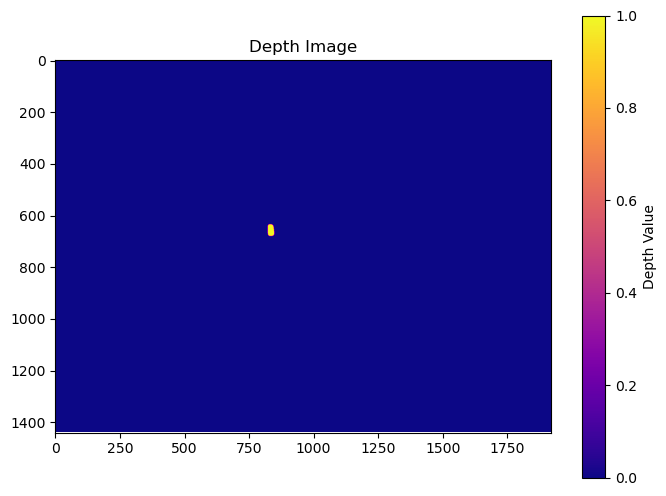

In [58]:
# Suppose depth is your 2D NumPy array
plt.figure(figsize=(8, 6))
plt.imshow(mask, cmap='plasma')  # 'plasma', 'viridis', or 'gray' are good for depth
plt.colorbar(label="Depth Value")
plt.title("Depth Image")
plt.show()

In [59]:
# compute the 3D-2D mapping based on the depth
mapping_seg = np.ones([num_points, 4], dtype=int) 
mapping_seg[:, 1:4] = compute_masked_mapping(camera_to_world=pose, coords=point_positions, mask=mask,  depth=depth, 
                                  intrinsic=intrinsic, image_dim=(width,height), cut_bound=5, vis_thres=0.25, device=device) 



In [60]:
points_mask_seg = mapping_seg[:, 3]
valid_point_mask_seg = points_mask_seg != 0 

In [61]:
mask_obj.shape

(1440, 1920)

In [62]:
final_point_mask = np.logical_and(valid_point_mask, valid_point_mask_seg)

In [63]:
points_colors[valid_point_mask_seg] = [0,1,0]

In [64]:
valid_point_mask_seg

array([False, False, False, ..., False, False, False])

In [65]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(point_positions)
pcd.colors = o3d.utility.Vector3dVector(points_colors)

In [ ]:
o3d.visualization.draw_geometries([pcd],
                                  )

In [153]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np


In [154]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    print(color.reshape(1, 1, -1).shape, mask.reshape(h, w, 1).shape) 
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1) 
    print(mask[np.nonzero(mask)[0]])
    plt.imshow(mask_image)
    
    ax.imshow(mask_image)

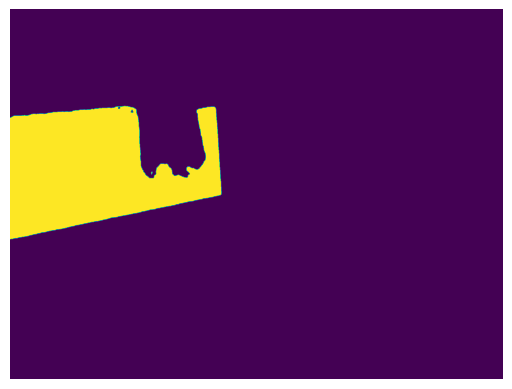

In [158]:
plt.imshow(np.array(image))
ax = plt.gca()
for i in range(1):
    #print(mask.shape)
    mask = masks[0][2][0]
    plt.imshow(mask)
    
    ax.imshow(mask)
    #show_mask(mask, ax=ax, random_color=False)
plt.axis("off")
plt.show()

In [75]:
masks[0][1].shape

torch.Size([3, 1440, 1920])

In [40]:
angle_scores, mod_scores = get_mask_score(mask)


In [41]:
angle_scores

3.233478841304535

In [42]:
mod_scores

3.36561552161389

In [43]:
mask = masks[0][0][1]

In [44]:
mask.shape

torch.Size([1440, 1920])

In [172]:
masks[0][2].numpy().shape


(3, 1440, 1920)

In [169]:
def convert_angle_axis_to_matrix3(angle_axis):
    """
    Converts a rotation from angle-axis representation to a 3x3 rotation matrix.

    Args:
        angle_axis (numpy.ndarray): A 3-element array representing the rotation in angle-axis form.

    Returns:
        (numpy.ndarray): A 3x3 rotation matrix representing the same rotation as the input angle-axis.

    Raises:
        ValueError: If the input is not a valid 3-element numpy array.
    """
    # Check if input is a numpy array
    if not isinstance(angle_axis, np.ndarray):
        raise ValueError("Input must be a numpy array.")
    
    # Check if the input is of shape (3,)
    if angle_axis.shape != (3,):
        raise ValueError("Input must be a 3-element array representing the rotation in angle-axis representation.")
    
    matrix, jacobian = cv2.Rodrigues(angle_axis)
    return matrix

In [46]:
import numpy as np
import cv2

In [47]:
def load_arkit_poses(traj_file):
    poses = []
    with open(traj_file, 'r') as f:
        for line in f:
            tokens = line.strip().split()
            if len(tokens) != 7:
                continue  # skip malformed lines
            ts = tokens[0]

            # Rotation in angle axis
            angle_axis = [float(tokens[1]), float(tokens[2]), float(tokens[3])]
            r_w_to_p = convert_angle_axis_to_matrix3(np.asarray(angle_axis))

            # Translation
            t_w_to_p = np.asarray([float(tokens[4]), float(tokens[5]), float(tokens[6])])
            extrinsics = np.eye(4, 4)
            extrinsics[:3, :3] = r_w_to_p
            extrinsics[:3, -1] = t_w_to_p
            Rt = extrinsics

            poses.append((ts, Rt))
    return poses


In [48]:
# Example usage
poses = load_arkit_poses(traj_path)

In [49]:
pose = poses[243][1]

In [50]:
pose.shape

(4, 4)

In [51]:
import numpy as np
def read_pincam_file(filepath):
    with open(filepath, 'r') as f:
        line = f.readline()
        parts = list(map(float, line.strip().split()))
        assert len(parts) == 6, "Expected 6 values: WIDTH HEIGHT fx fy cx cy"

        width, height, fx, fy, cx, cy = parts
        K = np.array([[fx, 0, cx],
                      [0, fy, cy],
                      [0,  0,  1]])

        image_size = (int(height), int(width))  # (H, W)

        return K, image_size


In [52]:
K, image_size = read_pincam_file(intrinsic_path)

In [53]:
K.shape

(3, 3)

In [54]:
T_lidar_to_cam = np.load(transform_path) 

In [55]:
T_lidar_to_cam.shape

(4, 4)

In [56]:
# read the pcd file 
pcd = o3d.io.read_point_cloud(pcd_file_path) 
points = np.asarray(pcd.points)
colors = np.asarray(pcd.colors) 

# read the crop index file to crop the noisy points 
crop_index = np.load(crop_file_path) 

points = points[crop_index]
colors = colors[crop_index]

In [57]:
def project_points_to_mask(points_lidar,colors, T_lidar_to_cam, K,pose, mask):
    # Convert points to homogeneous
    points_h = np.hstack([points_lidar, np.ones((points_lidar.shape[0], 1))])
    #print(points_h.shape)
    
    # Transform to camera frame
    points_cam_cord = (T_lidar_to_cam @ points_h.T).T[:, :3]
    #points_cam = points_lidar
    #print(points_cam.shape) 
    #pcd = o3d.geometry.PointCloud()
    #pcd.points = o3d.utility.Vector3dVector(points_cam_cord)
    #pcd.colors = o3d.utility.Vector3dVector(colors )
    #o3d.visualization.draw_geometries([pcd],)
                                  
    # Keep points in front of camera
    valid = points_cam_cord[:, 2] > 0
    points_cam = points_cam_cord[valid] 
    #pcd = o3d.geometry.PointCloud()
    #pcd.points = o3d.utility.Vector3dVector(points_cam)
    #pcd.colors = o3d.utility.Vector3dVector(colors[valid] )
    #o3d.visualization.draw_geometries([pcd],)
                                  
    #print(points_cam.shape)
    points_lidar_cam = points_lidar[valid] 
    colors_cam = colors[valid] 

    #pcd = o3d.geometry.PointCloud()
    #pcd.points = o3d.utility.Vector3dVector(points_lidar_cam)
    #pcd.colors = o3d.utility.Vector3dVector(colors_cam )
    #o3d.visualization.draw_geometries([pcd],)
    

    outside_cam_points = points_lidar[~valid] 
    outside_cam_colors = colors[~valid] 

    #pcd = o3d.geometry.PointCloud()
    #pcd.points = o3d.utility.Vector3dVector(outside_cam_points )
    #pcd.colors = o3d.utility.Vector3dVector(outside_cam_colors)
    #o3d.visualization.draw_geometries([pcd],)
    
    
    

    #print(points_lidar.shape)
    #print(T_lidar_to_cam.shape)
    points_cam =  np.hstack([points_cam, np.ones((points_cam.shape[0], 1))]) 
    points_after_pose = pose @ points_cam.T
    
    #pcd = o3d.geometry.PointCloud()
    #pcd.points = o3d.utility.Vector3dVector(points_after_pose.T[:, 0:3])
    #pcd.colors = o3d.utility.Vector3dVector(colors_cam)
    #o3d.visualization.draw_geometries([pcd],)
    
    
    # Project to image plane
    pixels = (K@ points_after_pose[0:3, :]).T 
    
    #print(pixels.shape)
    pixels /= pixels[:, 2:3]  # Normalize by z
    u = pixels[:, 0].astype(int)
    v = pixels[:, 1].astype(int)
    #print(mask.shape)
    H, W = mask.shape 
    inside = (u >= 0) & (u < W) & (v >= 0) & (v < H)
    outside_mask_points = points_lidar_cam[~inside] 
    outside_mask_colors = colors_cam[~inside] 

    #pcd = o3d.geometry.PointCloud()
    #pcd.points = o3d.utility.Vector3dVector(outside_mask_points)
    #pcd.colors = o3d.utility.Vector3dVector(outside_mask_colors)
    #o3d.visualization.draw_geometries([pcd],)
    
    
    u, v = u[inside], v[inside]
    points_lidar_mask = points_lidar_cam[inside] 
    color_mask = colors_cam[inside] 
    #n, _ = color_mask.shape
    #color_mask = np.zeros((n, 3))
    #print(points_lidar.shape)
    #pcd = o3d.geometry.PointCloud()
    #pcd.points = o3d.utility.Vector3dVector(points_lidar_mask)
    #pcd.colors = o3d.utility.Vector3dVector(color_mask)
    #o3d.visualization.draw_geometries([pcd],)
        
    return outside_cam_points, outside_mask_points, points_lidar_mask , outside_cam_colors, outside_mask_colors, color_mask
   

    

In [58]:
outside_cam_points, outside_mask_points, points_lidar_mask , outside_cam_colors, outside_mask_colors, color_mask = project_points_to_mask(points,colors, T_lidar_to_cam, K, pose,  mask)

In [59]:
points.shape

(6010016, 3)

In [60]:
colors.shape

(6010016, 3)

In [61]:
new_points = np.vstack((outside_cam_points, outside_mask_points, points_lidar_mask))
new_colors = np.vstack((outside_cam_colors, outside_mask_colors, color_mask))

In [62]:
new_points.shape

(6010016, 3)

In [63]:
colors.shape

(6010016, 3)

In [64]:
 points_lidar_mask

array([[-7.26001918e-01,  3.36170167e-01,  3.94974915e+02],
       [-7.30261028e-01,  3.31226021e-01,  3.94589935e+02],
       [-7.33365238e-01,  3.30598325e-01,  3.94799408e+02],
       ...,
       [-2.75541246e-02, -6.08261061e+00,  3.94089539e+02],
       [ 2.49890423e+00,  7.95314372e-01,  3.95368774e+02],
       [ 2.92300129e+00,  1.32856464e+00,  3.95362732e+02]])

In [65]:
color_mask

array([[0.59607843, 0.5254902 , 0.48627451],
       [0.65098039, 0.57647059, 0.57647059],
       [0.59607843, 0.50588235, 0.53333333],
       ...,
       [0.30980392, 0.30980392, 0.30980392],
       [0.85490196, 0.85490196, 0.85490196],
       [0.76470588, 0.76470588, 0.76470588]])

In [66]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(new_points)
pcd.colors = o3d.utility.Vector3dVector(new_colors )

In [67]:
o3d.visualization.draw_geometries([pcd],
                                  )

In [69]:
np.ones((3,3))

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [98]:
a = np.array([1,2,3])


array([1, 3])